# Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Linearized Ops --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [sa_03_iso_correctness.ipynb](sa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we continue the implementation of our *self adjoint* wave equation with dissipation only Q attenuation, and linearize the modeling operator with respect to the model parameter velocity. We show how to implement finite difference evolutions to compute the action of the ```forward``` and ```adjoint``` Jacobian. 

## Outline 
1. Define symbols 
2. The nonlinear operator 
3. The Jacobian opeator 
4. Create the Devito grid and model fields 
5. The simulation time range and acquistion geometry 
6. Implement and run the nonlinear forward operator 
7. Implement and run the Jacobian forward operator 
8. Implement and run the Jacobian adjoint operator 
9. References 


## Table of symbols

There are many more symbols for the Jacobian than we had in the previous notebook. We need to introduce terminology for the nonlinear operator, including total, background and perturbation fields for several variables.  

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $\omega_c = 2 \pi f$ | center angular frequency | constant |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $m(x,y,z)$ | Total P wave velocity ($m_0+\delta m$) | function of space |
| $m_0(x,y,z)$ | Background P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Background pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $q(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ | 

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

## The Nonlinear operator

The nonlinear operator is the solution to the self adjoint scalar isotropic variable density visco- acoustic wave equation shown immediately below, and maps the velocity model vector $m$ into the receiver wavefield vector $r$.

$$
\frac{b}{m^2} \left( \frac{\omega_c}{Q}\overleftarrow{\partial_t}\ u + \partial_{tt}\ u \right) =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
$$

In operator notation, where the operator is nonlinear with respect to model $m$ to the left of semicolon inside the square brackets, and linear with respect to the source $q$ to the right of semicolon inside the square brackets.

$$
F[m; q] = r
$$

## The Jacobian operator

In this section we linearize about a background model and take the derivative of the nonlinear operator to obtain the Jacobian forward operator. 

In operator notation, where the derivative of the modeling operator is now linear in the model perturbation vector $\delta m$, the Jacobian operator maps a perturbation in the velocity model $\delta m$ into a perturbation in the receiver wavefield $\delta r$.

$$
\nabla F[m; q]\ \delta m = \delta r
$$

#### 1. We begin by simplifying notation 
To simplify the treatment below we introduce the operator $L_t[\cdot]$, accounting for the time derivatives inside the parentheses on the left hand side of the wave equation. 

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$

Next we re-write the wave equation using this notation.

$$
\frac{b}{m^2} L_t[u] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
$$

#### 2. Linearize
To linearize we treat the total model as the sum of background and perturbation models $\left(m = m_0 + \delta m\right)$, and the total pressure as the sum of background and perturbation pressures $\left(u = u_0 + \delta u\right)$.

$$
\frac{b}{(m_0+\delta m)^2} L_t[u_0+\delta u] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} (u_0+\delta u) \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} (u_0+\delta u) \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} (u_0+\delta u) \right) + q
$$

Note that *model parameters* for this variable density isotropic visco-acoustic physics is only velocity, we do not treat perturbations to density.

We also write the PDE for the background model, which we subtract after linearization to simplify the final expression. 

$$
\frac{b}{m_0^2} L_t[u_0] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} u_0 \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} u_0 \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} u_0 \right) + q
$$

#### 3. Take derivative w.r.t. model parameters
Next we take the derivative with respect to velocity, keep only terms up to first order in the perturbations, subtract the background model PDE equation, and finally arrive at the following linearized equation:

$$
\frac{b}{m_0^2} L_t\left[\delta u\right] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x} \delta u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y} \delta u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z} \delta u \right) + 
    \frac{2\ b\ \delta m}{m_0^3} L_t\left[u_0\right]
$$

Note that the source $q$ in the original equation above has disappeared due to subtraction of the background PDE, and has been replaced by the *Born source*: 

$$
q = \frac{\displaystyle 2\ b\ \delta m}{\displaystyle m_0^3} L_t\left[u_0\right]
$$

This is the same equation as used for the nonlinear forward, only now in the perturbed wavefield $\delta u$ and with the Born source.

## The adjoint of the Jacobian operator

In this section we introduce the adjoint of the Jacobian operator we derived above. The Jacobian adjoint operator maps a perturbation in receiver wavefield $\delta r$ into a perturbation in velocity model $\delta m$. In operator notation:

$$
\bigl( \nabla F[m; q] \bigr)^\top\ \delta r = \delta m
$$

#### 1. Solve the time reversed wave equation with the receiver perturbation as source
The PDE for the adjoint of the Jacobian is solved for the perturbation to the pressure wavefield $\delta u$ by using the same wave equation as the nonlinear forward and the Jacobian forward, with the time reversed receiver wavefield perturbation $\widetilde{\delta r}$ injected as source. 

Note that we use $\widetilde{\delta u}$ and $\widetilde{\delta r}$ to indicate that we solve this finite difference evolution time reversed.

$$
\frac{b}{m_0^2} L_t\left[\widetilde{\delta u}\right] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ \widetilde{\delta u} \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ \widetilde{\delta u} \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ \widetilde{\delta u} \right) + 
    \widetilde{\delta r}
$$

#### 2. Compute zero lag correlation  

We compute the perturbation to the velocity model by zero lag correlation of the wavefield perturbation $\widetilde{\delta u}$ solved in step 1 as shown in the following expression: 

$$
\delta m(x,y,z) = \sum_t 
    \left\{ 
        \widetilde{\delta u}(t,x,y,z)\ 
        \frac{\displaystyle 2\ b}{\displaystyle m_0^3} L_t\bigl[u_0(t,x,y,z)\bigr]
    \right\}
$$

Note that this correlation can be more formally derived by examining the equations for two Green's functions, one for the background model ($m_0$) and wavefield ($u_0$), and one for for the total model $(m_0 + \delta m)$ and wavefield $(u_0 + \delta u)$, and subtracting to derive the equation for Born scattering.


## Implementation

Next we assemble the Devito objects needed to implement these linearized operators.

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import setup_w_over_q
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as in the previous notebook outlining implementation for the nonlinear forward.

In [2]:
# Define dimensions for the interior of the model
nx,nz = 401,401
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 80          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (401, 401)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (4000.0, 4000.0)

shape_pad;        [561 561]
origin_pad;       (-800.0, -800.0)
extent_pad;       (5600.0, 5600.0)

grid.shape;       (561, 561)
grid.extent;      (5600.0, 5600.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define velocity, buoyancy and $\frac{\omega_c}{Q}$ model parameters

We have the following constants and fields to define:

| &nbsp; Symbol &nbsp; | Description |
|:---:|:---|
| $$m0(x,z)$$ | Background velocity model |
| $$\delta m(x,z)$$ | Perturbation to velocity model |
| $$b(x,z)=\frac{1}{\rho(x,z)}$$ | Buoyancy (reciprocal density) |
| $$\omega_c = 2 \pi f_c$$      | Center angular frequency |
| $$\frac{1}{Q(x,z)}$$ | Inverse Q model used in the modeling system |


In [3]:
#NBVAL_INGNORE_OUTPUT

# Create the velocity and buoyancy fields as in the nonlinear notebook 
space_order = 8

# Wholespace velocity
m0 = Function(name='m0', grid=grid, space_order=space_order)
m0.data[:] = 1.5

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 15
x0 = shape_pad[0]//2
z0 = shape_pad[1]//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
b.data[:,:] = 1.0 / 1.0

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 1000.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

Operator `WOverQ_Operator` run in 0.01 s


## Define the simulation time range and the acquisition geometry 

#### Simulation time range: 

In this notebook we run 3 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/self_adjoint/utils.py```. 

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

#### Acquisition geometry: 

**source**:
- X coordinate: left sode of model
- Z coordinate: middle of model
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: right side of model
- Z coordinate: vertical line in model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

In [4]:
def compute_critical_dt(v):
    """
    Determine the temporal sampling to satisfy CFL stability.
    This method replicates the functionality in the Model class.
    Note we add a safety factor, reducing dt by a factor 0.75 due to the
    w/Q attentuation term.
    Parameters
    ----------
    v : Function
        velocity
    """
    coeff = 0.38 if len(v.grid.shape) == 3 else 0.42
    dt = 0.75 * v.dtype(coeff * np.min(v.grid.spacing) / (np.max(v.data)))
    return v.dtype("%.5e" % dt)

In [5]:
t0 = 0.0     # Simulation time start
tn = 1500.0  # Simulation time end (1 second = 1000 msec)
dt = compute_critical_dt(m0)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source at 1/4 X, 1/2 Z, Ricker with 10 Hz center frequency
src_nl = RickerSource(name='src_nl', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src_nl.coordinates.data[0,0] = dx * 1 * nx//4
src_nl.coordinates.data[0,1] = dz * shape[1]//2

# Receivers at 3/4 X, line in Z
rec_nl = Receiver(name='rec_nl', grid=grid, npoint=nz, time_range=time_range)
rec_nl.coordinates.data[:,0] = dx * 3 * nx//4
rec_nl.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src_nl.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src_nl.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,0]), np.max(rec_nl.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,1]), np.max(rec_nl.coordinates.data[:,1])))

Time min, max, dt, num;   0.000000 1500.000000   2.100000 715
time_range;  TimeAxis: start=0, stop=1501.5, step=2.1, num=716
src_coordinate  X;           +1002.0000
src_coordinate  Z;           +2005.0000
rec_coordinates X min/max;   +3007.0000   +3007.0000
rec_coordinates Z min/max;      +0.0000   +4000.0000


## Plot the model 

We plot the following ```Functions```:
- Background Velocity
- Background Density
- Velocity perturbation
- Q Model

Each subplot also shows:
- The location of the absorbing boundary as a dotted line
- The source location as a red star
- The line of receivers as a black vertical line

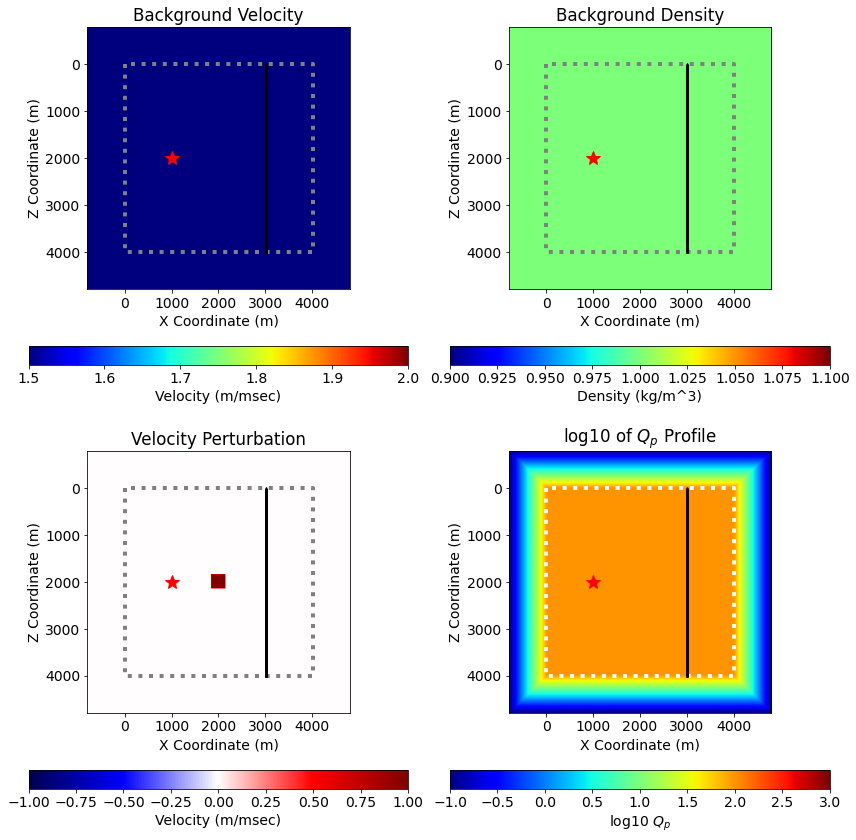

In [6]:
#NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0
pmin, pmax = -1, +1
bmin, bmax = 0.9, 1.1

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

plt.tight_layout()
None

## Define pressure wavefields

We need two wavefields for Jacobian operations, one computed during the finite difference evolution of the nonlinear forward operator $u_0(t,x,z)$, and one computed during the finite difference evolution of the Jacobian operator $\delta u(t,x,z)$. 

For this example workflow we will require saving all time steps from the nonlinear forward operator for use in the Jacobian operators. There are other ways to implement this requirement, including checkpointing, but that is way outside the scope of this illustrative workflow.  

In [7]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
u0 = TimeFunction(name="u0", grid=grid, time_order=2, space_order=space_order, save=nt)
duFwd = TimeFunction(name="duFwd", grid=grid, time_order=2, space_order=space_order, save=None)
duAdj = TimeFunction(name="duAdj", grid=grid, time_order=2, space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = u0.dimensions

## Implement and run the nonlinear operator

We next transcribe the time update expression for the nonlinear operator above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c code for performing the modeling.

We copy the time update expression from the first implementation notebook, but omit the source term $q$ because for the nonlinear operator we explicitly inject the source using ```src_term```. 

We think of this as solving for the *background wavefield* $u_0$ not the total wavefield $u$, and hence we use $v_0$ for velocity instead of $v$.

$$
\begin{aligned}
    u_0(t+\Delta_t) &=
        \frac{\Delta_t^2 v_0^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u_0 \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u_0 \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u_0 \right) + q
        \right] \\[5pt]
        &\quad +\ u_0(t) \left(2 - \frac{\Delta_t^2 \omega_c}{Q} \right)
        - u_0(t-\Delta_t) \left(1 - \frac{\Delta_t\ \omega_c}{Q} \right)
\end{aligned}
$$

## Self adjoint means support for nonlinear and linearized ops
Note that this stencil can be used for all of the operations we need, modulo the different source terms for the nonlinear and linearized forward evolutions:
1. the nonlinear forward (solved forward in time, $q$ is the usual source )
2. the Jacobian forward (solved forward in time, $q$ is the Born source )
3. the Jacobian adjoint (solved backward in time, $q$ is the time reversed receiver wavefield)

## Source injection and receiver extraction for nonlinear forward operator

Source injection and receiver extraction follow the implementation shown in the first notebook, please refer there for more information. 

In [8]:
#NBVAL_IGNORE_OUTPUT

# The nonlinear forward time update equation
eq_time_update_nl_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * u0.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * u0.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u0 + \
    (t.spacing * wOverQ - 1) * u0.backward

stencil_nl = Eq(u0.forward, eq_time_update_nl_fwd)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction
src_term_nl = src_nl.inject(field=u0.forward, expr=src_nl * t.spacing**2 * m0**2 / b)
rec_term_nl = rec_nl.interpolate(expr=u0.forward)

# Instantiate and run the operator for the nonlinear forward
op_nl = Operator([stencil_nl] + src_term_nl + rec_term_nl, subs=spacing_map)
u0.data[:] = 0
op_nl.apply()
None

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.1}


Operator `Kernel` run in 0.24 s


In [9]:
# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
# print(norm(u0))
assert np.isclose(norm(u0), 3382.059, atol=0, rtol=1e-3)

## Implement and run the Jacobian forward operator

We next transcribe the time update expression for the linearized operator into a Devito ```Eq```. Note that the source injection for the linearized operator is very different, and involves the Born source derived above *everywhere in space*. 

Please refer to the first notebook for the derivation of the time update equation if you don't follow this step.

$$
\begin{aligned}
    \delta u(t+\Delta_t) &=
        \frac{\Delta_t^2 v_0^2}{b} \left[ 
            \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ \delta u \right) +
            \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ \delta u \right) +
            \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ \delta u \right) + q
        \right] \\[5pt]
        &\quad +\ \delta u(t) \left(2 - \frac{\Delta_t^2 \omega_c}{Q} \right)
        - \delta u(t-\Delta_t) \left(1 - \frac{\Delta_t\ \omega_c}{Q} \right) \\[10pt]
    q &= \frac{2\ b\ \delta m}{m_0^3} L_t\left[u_0\right]
\end{aligned}
$$

## Source injection and receiver extraction for linearized forward operator

Note the source for the linearized forward operator is the Born source $q$, so we do not require a source injection term as with the nonlinear operator. 

As this is a forward operator, we are mapping into receiver gathers and therefore need to define both a container and an extraction term for receiver data.


In [10]:
#NBVAL_IGNORE_OUTPUT

# The linearized forward time update equation
eq_time_update_ln_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * duFwd.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * duFwd.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + 
     2 * b * dm * m0**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2)) +\
    (2 - t.spacing * wOverQ) * duFwd + \
    (t.spacing * wOverQ - 1) * duFwd.backward

stencil_ln_fwd = Eq(duFwd.forward, eq_time_update_ln_fwd)

# Receiver container and receiver extraction for the linearized operator
rec_ln = Receiver(name='rec_ln', grid=grid, npoint=nz, time_range=time_range)
rec_ln.coordinates.data[:,:] = rec_nl.coordinates.data[:,:]
rec_term_ln_fwd = rec_ln.interpolate(expr=duFwd.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd = Operator([stencil_ln_fwd] + rec_term_ln_fwd, subs=spacing_map)
duFwd.data[:] = 0
op_ln_fwd.apply()
None

Operator `Kernel` run in 0.26 s


In [11]:
# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
# print(norm(duFwd))
assert np.isclose(norm(duFwd), 328.049, atol=0, rtol=1e-3)

## Plot the computed nonlinear and linearized forward wavefields

Below we show the nonlinear wavefield at the end of the finite difference evolution, and the Born scattered wavefield at 3 different time steps showing 
1. Initial contact of the nonlinear wavefield with the scatterer (1.4 seconds)
2. Nonlinear wavefield has passed through the scatterer (1.8 seconds)
3. Linearized wavefield reaches the line of receivers (2.75 seconds)

You can clearly see both forward and backward scattered energy from the velocity perturbation. 

amax nl;     1.278353
amax ln t=1.50s;     1.094425


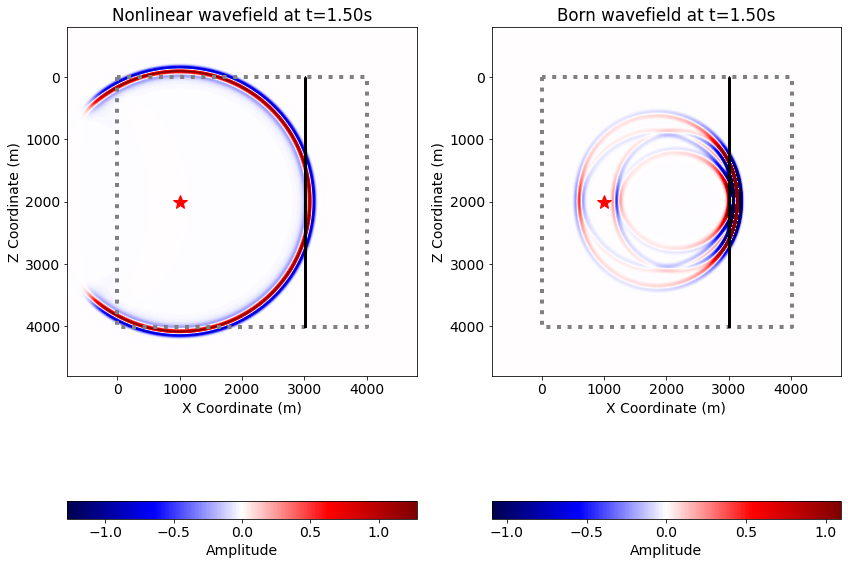

In [12]:
#NBVAL_INGNORE_OUTPUT

# Plot the two wavefields, each normalized to own maximum
kt  = nt - 2

amax_nl = 1.0 * np.max(np.abs(u0.data[kt,:,:]))
amax_ln = 0.1 * np.max(np.abs(duFwd.data[kt,:,:]))

print("amax nl; %12.6f" % (amax_nl))
print("amax ln t=%.2fs; %12.6f" % (dt * kt / 1000, amax_ln))

plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(u0.data[kt,:,:]), cmap="seismic", 
           vmin=-amax_nl, vmax=+amax_nl, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Nonlinear wavefield at t=%.2fs" % (dt * kt / 1000))

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(duFwd.data[kt,:,:]), cmap="seismic",
           vmin=-amax_ln, vmax=+amax_ln, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Born wavefield at t=%.2fs" % (dt * kt / 1000))

plt.tight_layout()
None

## An alternative implementation for the linearized forward

We would like to acknowledge Mathias Louboutin for an alternative method of implementing the linearized forward operator that is very efficient and perhaps novel. The driver code that implements the Jacobian forward operator (```examples/seismic/self_adjoint/operators.py```) can solve for both the nonlinear and linearized finite difference evolutions simultaneously. This implies significant performance gains with respect to cache pressure.

We outline below this code for your enjoyment, with line numbers added:

```
01 # Time update equations for nonlinear and linearized operators
02 eqn1 = iso_stencil(u0, model, forward=True)
03 eqn2 = iso_stencil(du, model, forward=True,
04                   q=2 * b * dm * v**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2))
05
06 # Inject the source into the nonlinear wavefield at u0(t+dt)
07 src_term = src.inject(field=u0.forward, expr=src * t.spacing**2 * v**2 / b)
08 
09 # Extract receiver wavefield from the linearized wavefield, at du(t)
10 rec_term = rec.interpolate(expr=du)
11 
12 # Create the operator
13 Operator(eqn1 + src_term + eqn2 + rec_term, subs=spacing_map,
14          name='ISO_JacobianFwdOperator', **kwargs)
```

One important thing to note about this code is the precedence of operations specified on the construction of the operator at line 13. It is guaranteed by Devito that ```eqn1``` will 'run' before ```eqn2```. This means that this specific order will occurr in the generated code: 
1. The nonlinear wavefield is advanced in time
2. The nonlinear source is injected in the nonlinear wavefield
3. The linearized wavefield is advanced in time
4. The linearixzed wavefield is interpolated at the receiever locations

As an exercise, you might implement this operator and print the generated c code to confirm this. 

## Implement and run the Jacobian adjoint operator

The linearized Jacobian adjoint uses the same time update equation as written above so we do not reproduce it here. Note that the finite difference evolution for the Jacobian adjoint runs *time-reversed* and a receiver wavefield is injected as source term. For this example we will inject the recorded linearized wavefield, which will provide an "image" of the Born scatterer. 

## Zero lag temporal correlation to build image

We rewrite the zero lag temporal correlation that builds up the image from above. The sum is achieved in Devito via ```Eq(dm, dm + <...>)```, where ```<...>``` is the operand of the zero lag correlation shown immediately below.

$$
\delta m(x,y,z) = \sum_t 
    \left\{ 
        \widetilde{\delta u}(t,x,y,z)\ 
        \frac{\displaystyle 2\ b}{\displaystyle m_0^3} L_t\left[u_0(t,x,y,z)\right]
    \right\}
$$

Note we instantiate a new ```Function``` $dm_a$ to hold the output from the linearized adjoint operator. 

## Source injection and receiver extraction for linearized adjoint operator

Note the source for the linearized adjoint operator is the receiver wavefield, injected time-reversed.

As this is an adjoint operator, we are mapping into the model domain and therefore do not need to define receivers.

In [13]:
#NBVAL_IGNORE_OUTPUT

# New Function to hold the output from the adjoint
dmAdj = Function(name='dmAdj', grid=grid, space_order=space_order)

# The linearized adjoint time update equation
# Note the small differencess from the linearized forward above
eq_time_update_ln_adj = (t.spacing**2 * m0**2 / b) * \
    ((b * duAdj.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * duAdj.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) +\
    (2 - t.spacing * wOverQ) * duAdj + \
    (t.spacing * wOverQ - 1) * duAdj.forward

stencil_ln_adj = Eq(duAdj.backward, eq_time_update_ln_adj)

# Equation to sum the zero lag correlation
dm_update = Eq(dmAdj, dmAdj +
               duAdj * (2 * b * m0**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2)))

# Receiver injection, time reversed
rec_term_ln_adj = rec_ln.inject(field=duAdj.backward, expr=rec_ln * t.spacing**2 * m0**2 / b)

# Instantiate and run the operator for the linearized forward
op_ln_adj = Operator([dm_update] + [stencil_ln_adj] + rec_term_ln_adj, subs=spacing_map)
op_ln_adj.apply()
None

Operator `Kernel` run in 0.33 s


In [14]:
# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
# print(norm(duAdj))
assert np.isclose(norm(duAdj), 27438.71, atol=0, rtol=1e-3)

## Plot the image

Below we plot the velocity perturbation and the "image" recovered from the linearized Jacobian adjoint. We normalize both fields to their maximum absolute value.

Note that with a single source and this transmission geometry, we should expect to see significant horizontal smearing in the image. 

amax dm;   5.000000e-01
amax dmAdj 5.945667e+02


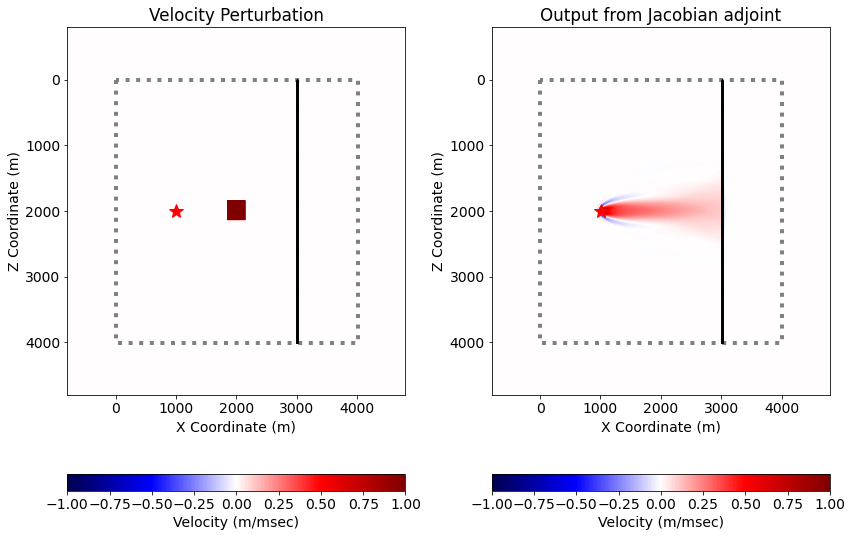

In [15]:
#NBVAL_INGNORE_OUTPUT

amax1 = 0.5 * np.max(np.abs(dm.data[:]))
amax2 = 0.5 * np.max(np.abs(dmAdj.data[:]))

print("amax dm;   %12.6e" % (amax1))
print("amax dmAdj %12.6e" % (amax2))

dm.data[:] = dm.data / amax1
dmAdj.data[:] = dmAdj.data / amax2

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent, aspect="auto")
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(dmAdj.data), cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent, aspect="auto")
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Output from Jacobian adjoint")

plt.tight_layout()
None

## Discussion

This concludes the implementation of the linearized Jacobian forward and adjoint operators. 

Please note there are details critical for practical use of these tools missing from this demonstration. In particular, for practical application to industry scale problems there would need to be a mechanism to save or checkpoint the wavefield from the nonlinear forward for use in the linearized finite difference evolutions.  

Please continue with the final notebook in this series concerning the correctness testing of these operators. 

[sa_03_iso_correctness.ipynb](sa_03_iso_correctness.ipynb)

## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
